## Deep Fake Detection Challenge

### Data Processing

##### Imports

In [90]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
from typing import Tuple
from model2D import *
from model3D import *

##### Data Description

In [91]:
train_videoes = "data/train_sample_videos"
test_videos = "data/test_videos"

print(f"Train Videoes: {len(os.listdir(train_videoes))}\nTest Vidoes: {len(os.listdir(test_videos))}")

Train Videoes: 401
Test Vidoes: 400


In [127]:
meta_data = pd.read_json(train_videoes+"/metadata.json").T
meta_data.head()
labels_col =meta_data["label"].to_list()
paths_col = meta_data.index.to_list()
paths_col
meta_data.original = np.where(meta_data.label == 'REAL', meta_data.index, meta_data.original)
meta_data = meta_data.sort_values(by="original")
print(meta_data)
labels_tsne = meta_data["original"].to_list()
print(labels_tsne)

               label  split        original
abarnvbtwb.mp4  REAL  train  abarnvbtwb.mp4
eepezmygaq.mp4  FAKE  train  abarnvbtwb.mp4
aelfnikyqj.mp4  REAL  train  aelfnikyqj.mp4
etmcruaihe.mp4  FAKE  train  afoovlsmtx.mp4
afoovlsmtx.mp4  REAL  train  afoovlsmtx.mp4
...              ...    ...             ...
dqppxmoqdl.mp4  FAKE  train  zrkinjhsuq.mp4
ckbdwedgmc.mp4  FAKE  train  zrkinjhsuq.mp4
cffffbcywc.mp4  FAKE  train  ztbinwxgyu.mp4
cmxcfkrjiv.mp4  FAKE  train  ztbinwxgyu.mp4
dlrsbscitn.mp4  FAKE  train  ztbinwxgyu.mp4

[400 rows x 3 columns]
['abarnvbtwb.mp4', 'abarnvbtwb.mp4', 'aelfnikyqj.mp4', 'afoovlsmtx.mp4', 'afoovlsmtx.mp4', 'agrmhtjdlk.mp4', 'ahqqqilsxt.mp4', 'ajqslcypsw.mp4', 'anpuvshzoo.mp4', 'asaxgevnnp.mp4', 'atkdltyyen.mp4', 'atkdltyyen.mp4', 'atvmxvwyns.mp4', 'atvmxvwyns.mp4', 'atvmxvwyns.mp4', 'atvmxvwyns.mp4', 'atvmxvwyns.mp4', 'atvmxvwyns.mp4', 'atvmxvwyns.mp4', 'avmjormvsx.mp4', 'avmjormvsx.mp4', 'axntxmycwd.mp4', 'aybgughjxh.mp4', 'aybumesmpk.mp4', 'aytzyidmgs.mp4

In [93]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    return unique_list

print(len(unique(labels_tsne)))

11


In [94]:
def visualize_real_vs_fake(class_count: list) -> None:
    plt.pie(class_count, labels=["Real Videos", "Deep Fake Videos"], autopct='%.2f%%',
       wedgeprops={'linewidth': 2.5, 'edgecolor': 'white'},
       textprops={'size': 'large', 'fontweight': 'bold'})
    plt.title("Proportion of Real vs Deep Fake videos in the training dataset.", fontdict={'fontweight': 'bold'})
    plt.legend([f"Real Videos Count: {class_count[0]}", f"Deep Fake Videos Count: {class_count[1]}"], bbox_to_anchor=(0.5, 0.05), bbox_transform=plt.gcf().transFigure, loc="lower center", prop={'weight':'bold'})
    plt.savefig("images/pie_chart_class_proportions.jpg")
    plt.show()

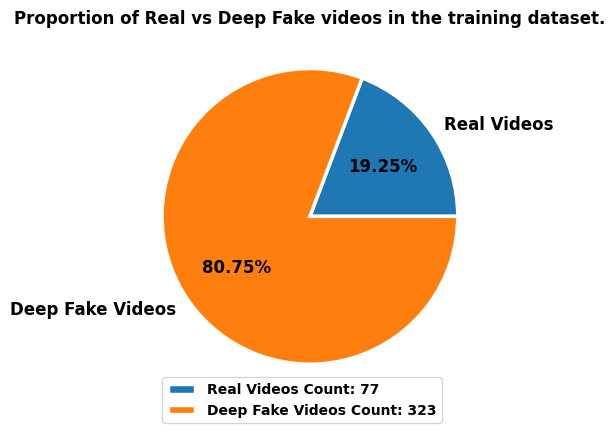

In [95]:
label_count_series = meta_data["label"].value_counts()
fake_count = label_count_series["FAKE"]
real_count = label_count_series["REAL"]

visualize_real_vs_fake([real_count, fake_count])

Quite skewed dataset. Might want to consider upsampling of real classes

In [133]:
def get_frames_v1(paths: list, frames_each_video: int, video_amount: int) -> list:
    video_array = []
    
    for idx, path in enumerate(paths): # bedre me enumerate her?
        if idx > video_amount:
            break
        vc = cv2.VideoCapture(path)
        frames_to_skip = (int(vc.get(cv2.CAP_PROP_FRAME_COUNT))-1)/frames_each_video
        frames_to_skip=round(frames_to_skip)
        """ print(int(vc.get(cv2.CAP_PROP_FRAME_COUNT)))
        if(int(vc.get(cv2.CAP_PROP_FRAME_COUNT))!=300):
            print(path)
            print(int(vc.get(cv2.CAP_PROP_FRAME_COUNT))) """
        video = []
        i = 0
        while vc.isOpened():
            i += 1
            ret, frame = vc.read()
            if ret and frame is not None:
                if i % frames_to_skip != 0:
                    continue
                if frame.shape[0] == 1920:
                    frame = frame.transpose(1, 0, 2)
                frame = cv2.resize(frame, (530, 300))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                video.append(frame)
            else:
                vc.release()
                break
        video_array.append(np.array(video))  
    return np.array(video_array)

training_videos_sample = os.listdir(train_videoes)
sample_file_names = training_videos_sample.copy()
sample_file_names=meta_data.index.to_list()
complete_paths = []
for i in range(len(sample_file_names)):
    if training_videos_sample[i].endswith('mp4'):
        complete_paths.append(train_videoes+"/"+sample_file_names[i])
#complete_paths.sort()
video_array = get_frames_v1(paths=complete_paths, frames_each_video=1, video_amount=400)


In [97]:

print(sample_file_names)

['abarnvbtwb.mp4', 'eepezmygaq.mp4', 'aelfnikyqj.mp4', 'etmcruaihe.mp4', 'afoovlsmtx.mp4', 'agrmhtjdlk.mp4', 'ahqqqilsxt.mp4', 'ajqslcypsw.mp4', 'anpuvshzoo.mp4', 'asaxgevnnp.mp4', 'atkdltyyen.mp4', 'cksanfsjhc.mp4', 'cycacemkmt.mp4', 'dakqwktlbi.mp4', 'czmqpxrqoh.mp4', 'bqkdbcqjvb.mp4', 'abofeumbvv.mp4', 'atvmxvwyns.mp4', 'cdyakrxkia.mp4', 'ehfiekigla.mp4', 'avmjormvsx.mp4', 'axntxmycwd.mp4', 'aybgughjxh.mp4', 'aybumesmpk.mp4', 'agqphdxmwt.mp4', 'aytzyidmgs.mp4', 'bddjdhzfze.mp4', 'etohcvnzbj.mp4', 'bdnaqemxmr.mp4', 'beboztfcme.mp4', 'ehdkmxgtxh.mp4', 'bejhvclboh.mp4', 'beyebyhrph.mp4', 'dfbpceeaox.mp4', 'bffwsjxghk.mp4', 'bgvhtpzknn.mp4', 'bgwmmujlmc.mp4', 'dzvyfiarrq.mp4', 'bilnggbxgu.mp4', 'bmjzrlszhi.mp4', 'bpapbctoao.mp4', 'brwrlczjvi.mp4', 'bsqgziaylx.mp4', 'bulkxhhknf.mp4', 'aorjvbyxhw.mp4', 'bwhlgysghg.mp4', 'coadfnerlk.mp4', 'cknyxaqouy.mp4', 'bwipwzzxxu.mp4', 'bxzakyopjf.mp4']


In [98]:
print(video_array.shape)

(20, 1, 720, 1280, 3)


In [99]:
y = [0 if val!="FAKE" else 1 for val in labels_col ]
y =np.array(y)


In [100]:
print(f"Amount of Videos: {len(video_array)}")
print(f"Frames for videos: {[len(video_array[i]) for i in range(len(video_array))]}")

Amount of Videos: 20
Frames for videos: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


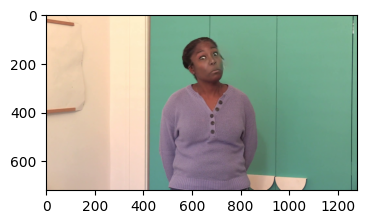

In [101]:
def plot_video(video: list, figsize: tuple, width: int, height: int) -> None:
    fig = plt.figure(figsize=figsize)
    for i in range(len(video[:(width*height)])):
        plt.subplot(width, height, i+1)
        plt.imshow(video[i])
    plt.show()

plot_video(video_array[1], (30,5), 2, 5)

In [134]:
from sklearn.manifold import TSNE
##frames_array = np.array([arr[0].flatten() for arr in video_array])
#frames_array = np.array([frame.flatten() for arr in video_array for frame in arr[:2]])
frames_array = np.array([frame[0].flatten() for frame in video_array])
# Instantiate t-SNE object with desired parameters
tsne = TSNE(n_components=2, perplexity=5, random_state=0)

# Fit t-SNE on the frames array
frames_tsne = tsne.fit_transform(frames_array)

399
399


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [135]:
unique_strings = set(labels_tsne)
string_to_index = {string: index for index, string in enumerate(unique_strings)}
new_list = [string_to_index[string] for string in labels_tsne]

ValueError: 'c' argument has 400 elements, which is inconsistent with 'x' and 'y' with size 399.

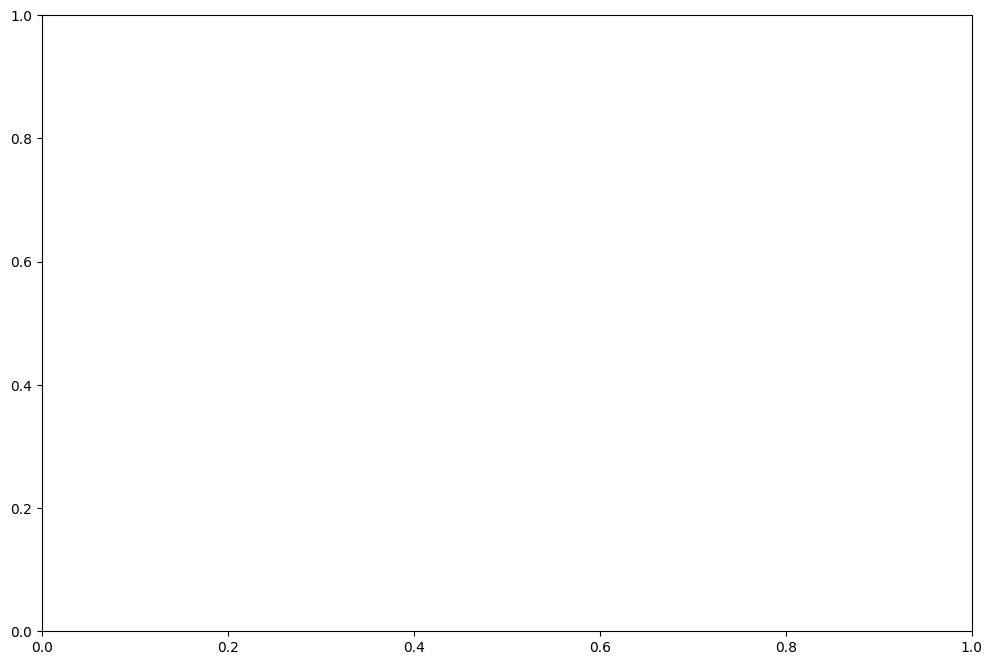

In [136]:
# Assuming labels is a list of labels corresponding to each frame
plt.figure(figsize=(12, 8))
num_colors = len(unique_strings)
colors = plt.cm.viridis(np.linspace(0, 1, num_colors))
plot = plt.scatter(frames_tsne[:,0], frames_tsne[:,1], c=new_list,cmap="jet")
plt.colorbar()
plt.legend(handles = plot.legend_elements()[0],labels=list(unique_strings))
plt.show()

In [112]:
labels_tsne

['abarnvbtwb.mp4',
 'abarnvbtwb.mp4',
 'aelfnikyqj.mp4',
 'afoovlsmtx.mp4',
 'afoovlsmtx.mp4',
 'agrmhtjdlk.mp4',
 'ahqqqilsxt.mp4',
 'ajqslcypsw.mp4',
 'anpuvshzoo.mp4',
 'asaxgevnnp.mp4',
 'atkdltyyen.mp4',
 'atkdltyyen.mp4',
 'atvmxvwyns.mp4',
 'atvmxvwyns.mp4',
 'atvmxvwyns.mp4',
 'atvmxvwyns.mp4',
 'atvmxvwyns.mp4',
 'atvmxvwyns.mp4',
 'atvmxvwyns.mp4',
 'avmjormvsx.mp4']

In [105]:
def format_frames(vid_arr):
    flatten_first_video_frame = vid_arr[0][0]
    flatten_first_video_frame = flatten_first_video_frame / 255
    return np.array([flatten_first_video_frame])
first_frame_formatted = format_frames(video_array)
first_frame_formatted.shape

(1, 720, 1280, 3)

### BUILD MODEL
- Add Layers
- Add Loss function, optimizers, and metrics
- Compile model and Fit

In [106]:
model_2D = build_2D_model(first_frame_formatted)
model_2D.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 720, 1280, 32)     4736      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 240, 426, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 240, 426, 3)       867       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 80, 142, 3)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 80, 142, 3)        84        
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 47, 3)       

In [107]:
model_2D = compile_2D_model(model_2D, 0.001)

In [108]:
video_array.shape

(20, 1, 720, 1280, 3)

In [109]:
model_3D = build_3D_model(video_array)
model_3D.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 1, 720, 1280, 6)   492       
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 1, 360, 640, 6)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 1, 360, 640, 3)    489       
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 1, 180, 320, 3)   0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 1, 180, 320, 3)    246       
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 1, 90, 160, 3)   

In [110]:
print(video_array.shape[0])

20


In [111]:
#model_3D = build_3D_model(video_array)
model_3D.fit(video_array,y[:video_array.shape[0]],epochs=5,steps_per_epoch=1,batch_size=2)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
metrics=["accuracy"]
model_3D.compile(optimizer=optimizer, loss=loss, metrics=metrics)